### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score

### Reading the CSV file

In [2]:
suicide_depression_data = pd.read_csv('Suicide_Detection.csv')

In [3]:
suicide_depression_data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
suicide_depression_data.shape

(232074, 3)

### Dropping the un-necessary 'Unnamed: 0' column

In [5]:
suicide_depression_data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [6]:
suicide_depression_data.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


### Checking for null values

In [7]:
suicide_depression_data.isnull().sum()

text     0
class    0
dtype: int64

### Getting information out about the dataset

In [8]:
suicide_depression_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


### Removing duplicated rows

In [9]:
suicide_depression_data.duplicated().sum()

0

### Initializing LabelEncoder to encode the labels

In [10]:
label_encoder = LabelEncoder()

### Encoding the labels

In [11]:
suicide_depression_data['class_num'] = label_encoder.fit_transform(suicide_depression_data['class'])

In [12]:
suicide_depression_data.head()

,text,class,class_num
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,Am I weird I don't get affected by compliments...,non-suicide,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


### Dropping the textual class column

In [13]:
suicide_depression_data.drop(columns=['class'], inplace=True)

In [14]:
suicide_depression_data.head()

,text,class_num
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [15]:
suicide_depression_data['class_num'].value_counts()

1    116037
0    116037
Name: class_num, dtype: int64

### Plotting total number of depression labels and not-depression labels

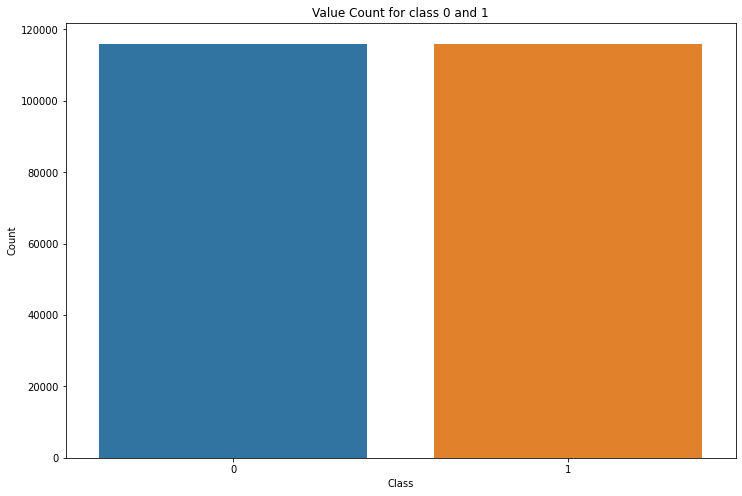

In [16]:
plt.figure(figsize=(12, 8))

sns.barplot(x=suicide_depression_data['class_num'].value_counts().index, y=suicide_depression_data['class_num'].value_counts().values)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Value Count for class 0 and 1')

plt.show()

In [17]:
suicide_data = suicide_depression_data[suicide_depression_data['class_num'] == 1]
not_suicide_data = suicide_depression_data[suicide_depression_data['class_num'] == 0]

In [18]:
suicide_data.shape

(116037, 2)

In [19]:
not_suicide_data.shape 

(116037, 2)

### Selecting first 5000 data that are suidical/depression and first 5000 data that are non suidical/depression

In [20]:
suicide_data_first_twofiftyhundered = suicide_data[:5000]
not_suicide_first_twofiftyhundered = not_suicide_data[:5000]

In [21]:
suicide_data_first_twofiftyhundered.shape

(5000, 2)

In [22]:
not_suicide_first_twofiftyhundered.shape

(5000, 2)

### Creating a new dataset out of the selected datas

In [23]:
suicide_depression_data_new = pd.concat([suicide_data_first_twofiftyhundered, not_suicide_first_twofiftyhundered], axis=0)

In [24]:
suicide_depression_data_new.to_csv('Suicide_Detection_small.csv')

In [25]:
suicide_depression_data_new = pd.read_csv('Suicide_Detection_small.csv')

In [26]:
suicide_depression_data_new.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [27]:
suicide_depression_data_new.head()

,text,class_num
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,i need helpjust help me im crying so hard,1
2,"I’m so lostHello, my name is Adam (16) and I’v...",1
3,Honetly idkI dont know what im even doing here...,1
4,[Trigger warning] Excuse for self inflicted bu...,1


### Feature Engineering

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91933\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91933\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
ps = PorterStemmer()

In [31]:
def preprocess_text(text):

  text = text.lower()

  text = nltk.word_tokenize(text)

  word_arr = []

  for i in text:
    if i.isalnum():
      word_arr.append(i)

  text = word_arr[:]

  word_arr.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      word_arr.append(i)

  text = word_arr[:]

  word_arr.clear()

  for i in text:
    word_arr.append(ps.stem(i))

  return " ".join(word_arr)

In [32]:
suicide_depression_data_new['preprocessed_text'] = suicide_depression_data_new['text'].apply(preprocess_text)

In [33]:
suicide_depression_data_new.head()

,text,class_num,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,1,ex wife threaten suiciderec left wife good che...
1,i need helpjust help me im crying so hard,1,need helpjust help im cri hard
2,"I’m so lostHello, my name is Adam (16) and I’v...",1,losthello name adam 16 struggl year afraid pas...
3,Honetly idkI dont know what im even doing here...,1,honetli idki dont know im even feel like noth ...
4,[Trigger warning] Excuse for self inflicted bu...,1,trigger warn excus self inflict burn know cris...


In [34]:
suicide_depression_data_new.drop(columns=['text'], axis=1, inplace=True)

In [35]:
suicide_depression_data_new.head()

,class_num,preprocessed_text
0,1,ex wife threaten suiciderec left wife good che...
1,1,need helpjust help im cri hard
2,1,losthello name adam 16 struggl year afraid pas...
3,1,honetli idki dont know im even feel like noth ...
4,1,trigger warn excus self inflict burn know cris...


### Creating a wordcloud out of the suicide/depression data and non-suicide/depression data

In [36]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

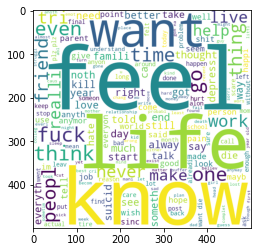

In [37]:
suicideDepressionWordCloud = wc.generate(suicide_depression_data_new[suicide_depression_data_new['class_num'] == 1]['preprocessed_text'].str.cat(sep=" "))

plt.imshow(suicideDepressionWordCloud)

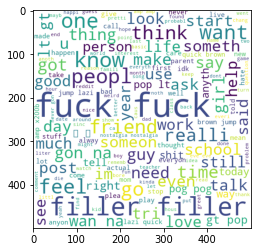

In [38]:
notSuicideDepressionWordCloud = wc.generate(suicide_depression_data_new[suicide_depression_data_new['class_num'] == 0]['preprocessed_text'].str.cat(sep=" "))

plt.imshow(notSuicideDepressionWordCloud)

### Initializing Vectorizer

In [39]:
vectorizer = TfidfVectorizer(max_features=3000)

### Vectorizing the feature and separating features and labels

In [40]:
X = vectorizer.fit_transform(suicide_depression_data_new['preprocessed_text']).toarray()
y = suicide_depression_data_new['class_num'].values

### Applying train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Initializing the models

In [42]:
random_forest_model = RandomForestClassifier(n_estimators=100)
svc_model = SVC(kernel='linear')
gaussian_nb_model = GaussianNB()
multinomial_nb_model = MultinomialNB()

### Using RandomForestClassifier

In [43]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
prediction_X_train = random_forest_model.predict(X_train)

accuracy_train_random_forest = accuracy_score(y_train, prediction_X_train)

print(accuracy_train_random_forest)

0.999375


In [45]:
prediction_X_test = random_forest_model.predict(X_test)

accuracy_test_random_forest = accuracy_score(y_test, prediction_X_test)

print(accuracy_test_random_forest)

0.8865


### Using Support Vector Classifier

In [46]:
svc_model.fit(X_train, y_train)

SVC(kernel='linear')

In [47]:
prediction_X_train = svc_model.predict(X_train)

accuracy_train_svc = accuracy_score(y_train, prediction_X_train)

print(accuracy_train_svc)

0.951


In [48]:
prediction_X_test = svc_model.predict(X_test)

accuracy_test_svc = accuracy_score(y_test, prediction_X_test)

print(accuracy_test_svc)

0.9025


### Using GaussianNB

In [49]:
gaussian_nb_model.fit(X_train, y_train)

GaussianNB()

In [50]:
prediction_X_train = gaussian_nb_model.predict(X_train)

accuracy_train_gaussiannb = accuracy_score(y_train, prediction_X_train)

print(accuracy_train_gaussiannb)

0.881125


In [51]:
prediction_X_test = gaussian_nb_model.predict(X_test)

accuracy_test_gaussiannb = accuracy_score(y_test, prediction_X_test)

print(accuracy_test_gaussiannb)

0.812


### Using MultinomialNB

In [52]:
multinomial_nb_model.fit(X_train, y_train)

MultinomialNB()

In [53]:
prediction_X_train = multinomial_nb_model.predict(X_train)

accuracy_train_multinomialnb = accuracy_score(y_train, prediction_X_train)

print(accuracy_train_multinomialnb)

0.9065


In [54]:
prediction_X_test = multinomial_nb_model.predict(X_test)

accuracy_test_multinomialnb = accuracy_score(y_test, prediction_X_test)

print(accuracy_test_multinomialnb)

0.872


### Creating a dataframe out of all the training and testing accuracies of all the models

In [55]:
accuracy_dataframe = pd.DataFrame({
    'Name of the Model': ['RandomForestClassifier', 'Support Vector Classifier', 'GaussianNB', 'MultinomialNB'],
    'Training Accuracy': [accuracy_train_random_forest, accuracy_train_svc, accuracy_train_gaussiannb, accuracy_train_multinomialnb],
    'Testing Accuracy': [accuracy_test_random_forest, accuracy_test_svc, accuracy_test_gaussiannb, accuracy_test_multinomialnb]
})

In [56]:
accuracy_dataframe

,Name of the Model,Training Accuracy,Testing Accuracy
0,RandomForestClassifier,0.999375,0.8865
1,Support Vector Classifier,0.951000,0.9025
2,GaussianNB,0.881125,0.8120
3,MultinomialNB,0.906500,0.8720


<AxesSubplot:xlabel='Name of the Model'>

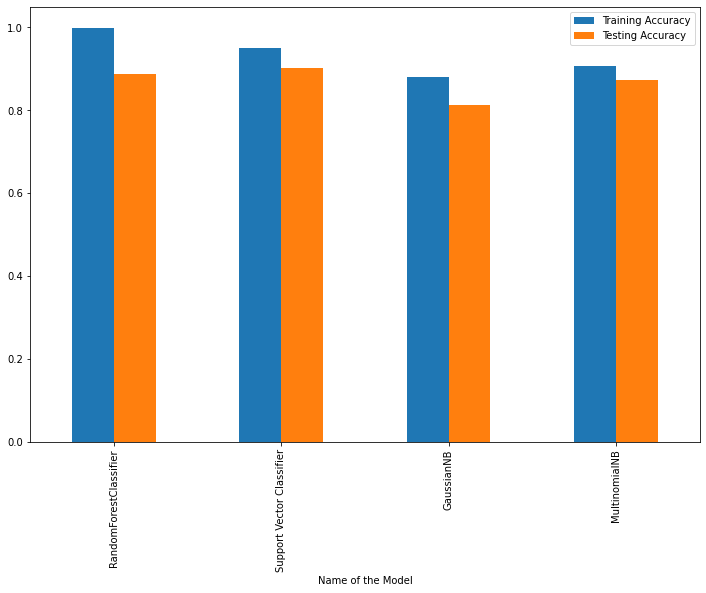

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))

accuracy_dataframe.plot(kind='bar', x='Name of the Model', ax=ax)

#### From the above accuracy table and graph, we can understand that SVC stands out to be the best model for our use case out of the 4 models.

### Creating a pickle file out of the ml model

In [58]:
import pickle

with open('mymodel.pkl', 'wb') as f:
    pickle.dump(svc_model, f)

### Creating a pickle file of the vectorizer

In [59]:
import pickle

with open('myvectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)